In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('./data/penguins_lter.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   studyName            344 non-null    object 
 1   Sample Number        344 non-null    int64  
 2   Species              344 non-null    object 
 3   Region               344 non-null    object 
 4   Island               344 non-null    object 
 5   Stage                344 non-null    object 
 6   Individual ID        344 non-null    object 
 7   Clutch Completion    344 non-null    object 
 8   Date Egg             344 non-null    object 
 9   Culmen Length (mm)   342 non-null    float64
 10  Culmen Depth (mm)    342 non-null    float64
 11  Flipper Length (mm)  342 non-null    float64
 12  Body Mass (g)        342 non-null    float64
 13  Sex                  334 non-null    object 
 14  Delta 15 N (o/oo)    330 non-null    float64
 15  Delta 13 C (o/oo)    331 non-null    flo

Dátová sada obsahuje 344 riadkov a 17 stĺpcov.
## Doplnenie chýbajúcich hodnôt
Zistime počet chýbajúcich hodnôt.

In [3]:
# pocet
df.isna().sum()

# percentaz chybajucich hodnot
# df.isnull().sum() * 100 / df.shape[0]

studyName                0
Sample Number            0
Species                  0
Region                   0
Island                   0
Stage                    0
Individual ID            0
Clutch Completion        0
Date Egg                 0
Culmen Length (mm)       2
Culmen Depth (mm)        2
Flipper Length (mm)      2
Body Mass (g)            2
Sex                     10
Delta 15 N (o/oo)       14
Delta 13 C (o/oo)       13
Comments               318
dtype: int64

Z vypísania dátovej sady sme zistili, že dve vzorky tučniakov (3, 339) neobsahujú väčšinu parametrov. Jedna z ponzámok napovedá, že dospelý jedinec nebol  odmeraný, tak tieto chybné vzorky odstránime. Doplňme ostatné chýbajúce číselné hodnoty vzoriek z krvi (Delta 15, Delta 13) ich strednou hodnotou. Percentuálne tieto chýbajúce hodnoty zaberajú ~3.5 % miesta v dátovej sade. Ďalej už len ostáva doplniť chýbajúce pohlavia tučniakov (~2 %) najčastejšou vyskytovanou hodnotou v sade. Taktiež vzorka tučniaka na riadku s indexom 336 obsahuje chybnú hodnotu (`.`) pohlavia. Nahradíme ju modusom tiež.

In [4]:
# odstranenie chybajucich vzoriek
bad_samples = [3, 339]
for x in bad_samples: df.drop(x, axis=0, inplace=True, errors = 'ignore')

# doplnenie vzoriek z krvi ich strednou hodnotou
missing_values = ['Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']
for x in missing_values : df[x].fillna(value = df[x].mean(), inplace=True)

# doplnenie pohlavia modusom
df['Sex'].fillna(df['Sex'].mode().values[0], inplace=True)
df.loc[336,'Sex'] = 'MALE'
df.isna().sum()

studyName                0
Sample Number            0
Species                  0
Region                   0
Island                   0
Stage                    0
Individual ID            0
Clutch Completion        0
Date Egg                 0
Culmen Length (mm)       0
Culmen Depth (mm)        0
Flipper Length (mm)      0
Body Mass (g)            0
Sex                      0
Delta 15 N (o/oo)        0
Delta 13 C (o/oo)        0
Comments               317
dtype: int64

## Odstránenie nepotrebných hodnôt
Z dátovej sady môžeme zmazať identifikačné hodnoty, ktorých kombinácia len identifikuje konkrétneho tučniaka - Individual ID, Sample Number.
Komentáre k odberu vzoriek sú taktiež nepotrebné na ďalšiu analýzu.

In [5]:
df.drop(['Individual ID', "Sample Number", "Comments", "Region", "Stage"], axis = 1, inplace=True, errors = 'ignore')

## Rozložení hodnot

In [6]:
df.head()

studyName                              Species     Island Clutch Completion  \
0   PAL0708  Adelie Penguin (Pygoscelis adeliae)  Torgersen               Yes   
1   PAL0708  Adelie Penguin (Pygoscelis adeliae)  Torgersen               Yes   
2   PAL0708  Adelie Penguin (Pygoscelis adeliae)  Torgersen               Yes   
4   PAL0708  Adelie Penguin (Pygoscelis adeliae)  Torgersen               Yes   
5   PAL0708  Adelie Penguin (Pygoscelis adeliae)  Torgersen               Yes   

   Date Egg  Culmen Length (mm)  Culmen Depth (mm)  Flipper Length (mm)  \
0  11/11/07                39.1               18.7                181.0   
1  11/11/07                39.5               17.4                186.0   
2  11/16/07                40.3               18.0                195.0   
4  11/16/07                36.7               19.3                193.0   
5  11/16/07                39.3               20.6                190.0   

   Body Mass (g)     Sex  Delta 15 N (o/oo)  Delta 13 C (o/oo)  
0         3750.0    MALE           8.733382         -25.686292  
1         3800.0  FEMALE           8.949560         -24.694540  
2         3250.0  FEMALE           8.368210         -25.333020  
4         3450.0  FEMALE           8.766510         -25.324260  
5         3650.0    MALE           8.664960         -25.298050

In [7]:
df.replace({"Adelie Penguin (Pygoscelis adeliae)"	: "Adelie", "Gentoo penguin (Pygoscelis papua)": "Gentoo", "Chinstrap penguin (Pygoscelis antarctica)" : "Chinstrap"}, inplace=True)

<AxesSubplot: xlabel='Species', ylabel='Flipper Length (mm)'>

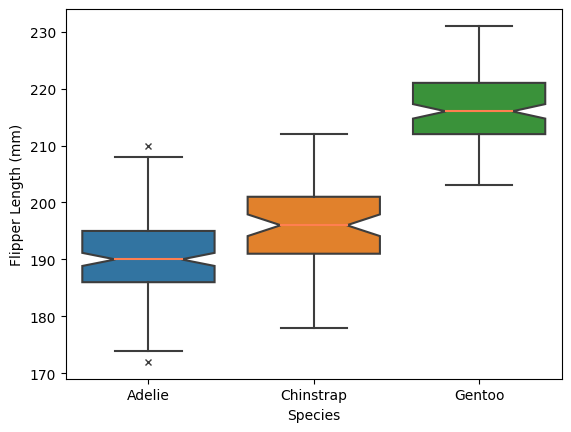

In [8]:
sns.boxplot(
    data=df, x="Species", y="Flipper Length (mm)",
    notch=True, showcaps=True,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},
)

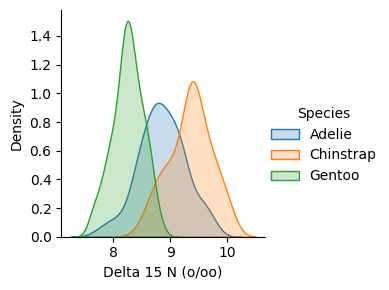

In [9]:
sns.FacetGrid(df, hue="Species") \
   .map(sns.kdeplot, "Delta 15 N (o/oo)", fill=True) \
   .add_legend()

<AxesSubplot: xlabel='Species', ylabel='Body Mass (g)'>

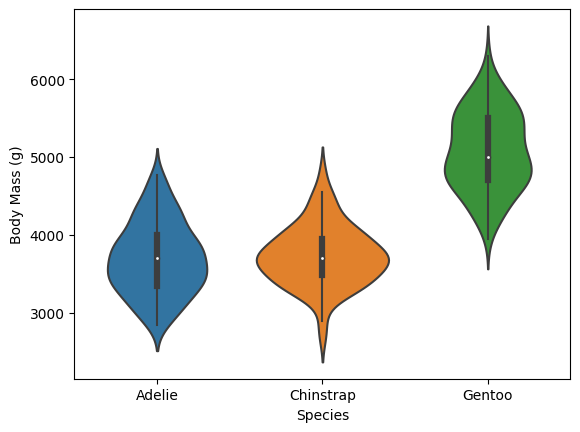

In [10]:
sns.violinplot(
    data=df, x="Species", y="Body Mass (g)",
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)

# sns.FacetGrid(df, hue="Species") \
#    .map(sns.violinplot, "Body Mass (g)", fill=True) \
#    .add_legend()

<AxesSubplot: xlabel='Species', ylabel='Body Mass (g)'>

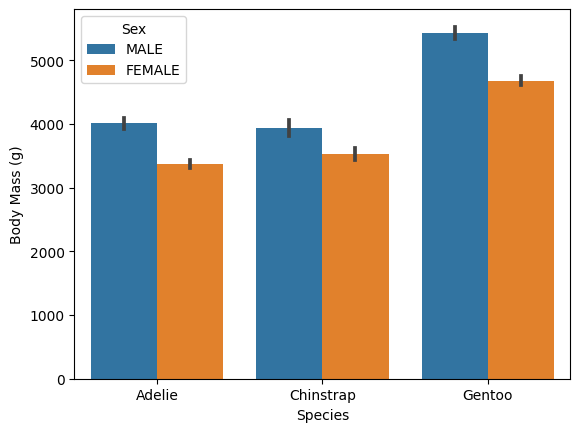

In [11]:
sns.barplot(data=df, x="Species", y="Body Mass (g)", hue="Sex")

## Korelácia

<Figure size 700x700 with 0 Axes>

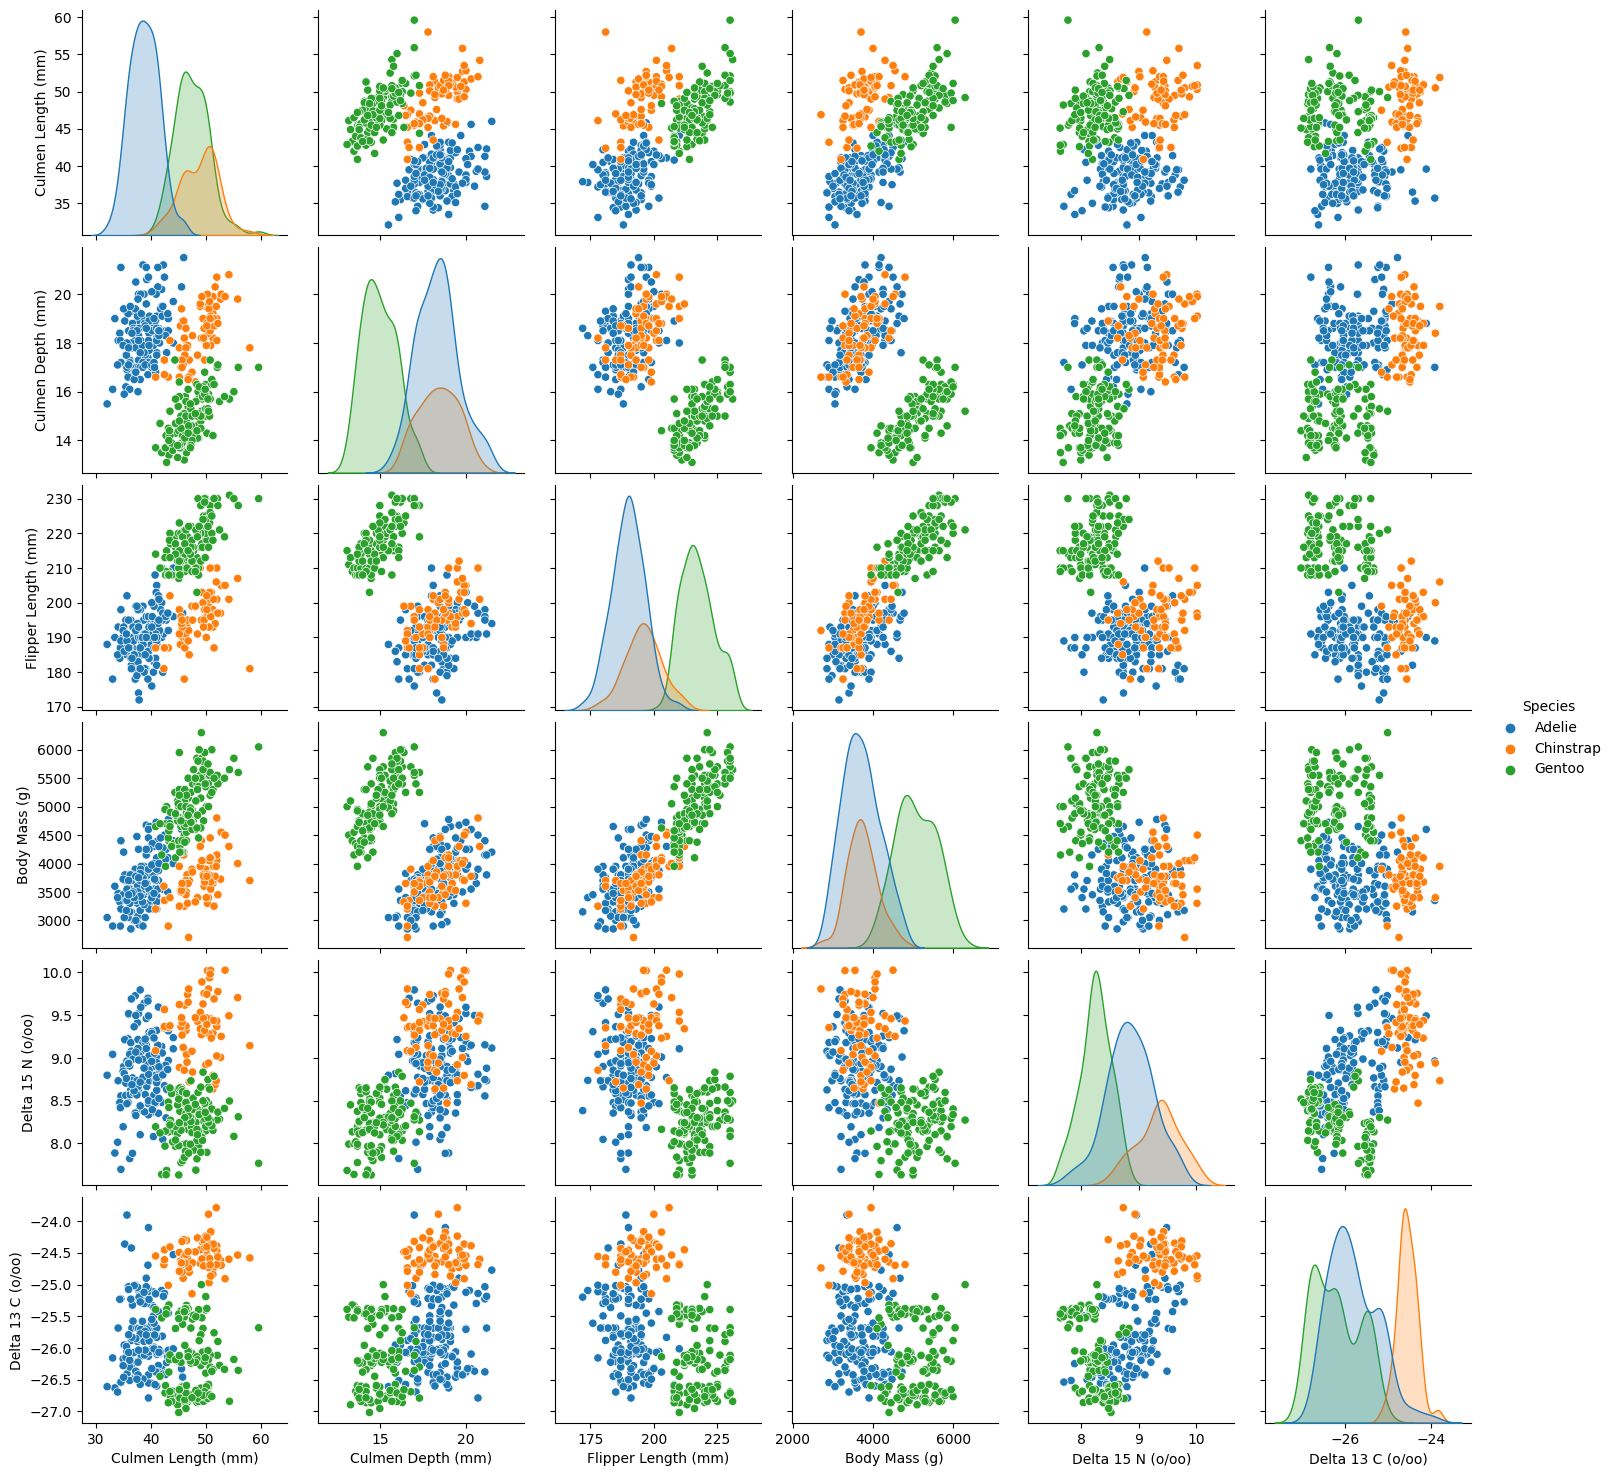

In [12]:
plt.figure(figsize=(7,7))
#sns.set_style('whitegrid')
sns.pairplot(data=df, hue='Species')#, palette=('DarkOrange', 'MediumOrchid', 'Teal'))

Z grafu na prvý pohľad sa dá vyčítať, že je vysoká korelácia medzi dĺžkou plutvy a váhou tučniaka. Poďme toto tvrdenie overiť aj na korelačnej matici.

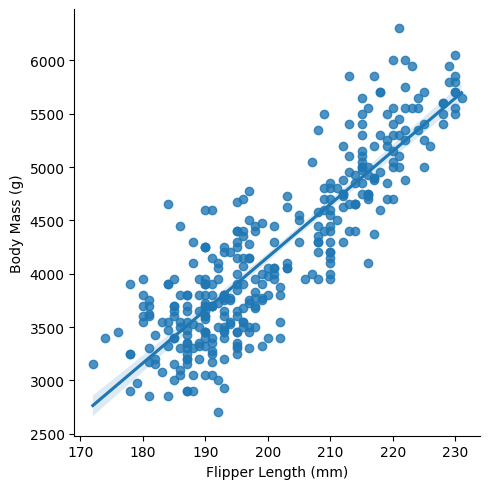

In [13]:
sns.lmplot(data=df, x="Flipper Length (mm)", y="Body Mass (g)", )

<AxesSubplot: >

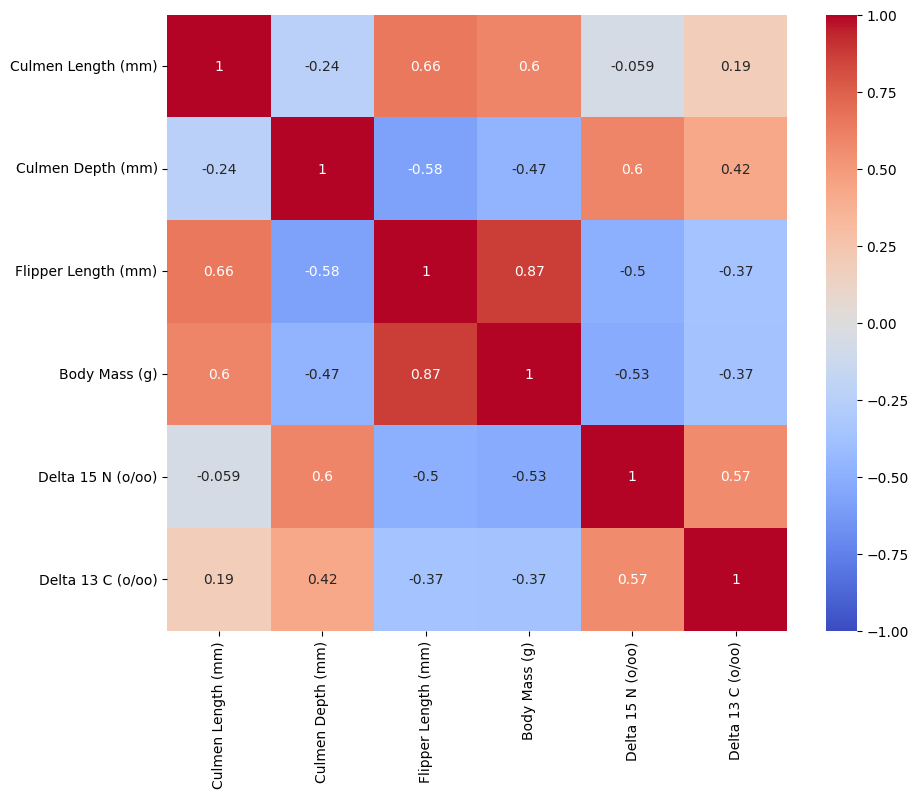

In [14]:
correlations = df.corr(method="pearson", numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, vmin= -1, cmap="coolwarm", annot=True)

Korelačná matica povtvrdila, že je medzi týmito parametrami celkom veľká korelácia (0,87).

## Uprava datovej sady

kategoricke -> numericke


In [15]:
df_normalized_base = df[['Flipper Length (mm)', 'Culmen Length (mm)', 'Culmen Depth (mm)', 'Body Mass (g)']]
df_1_normalized = df_normalized_base.apply(lambda iterator: ((iterator - iterator.min())/(iterator.max() - iterator.min())))
df_1_normalized['Species'] = df[['Species']]
df_1_normalized['Island'] = df[['Island']].replace({"Dream"	: 0, "Torgersen": 1, "Biscoe" : 2})
df_1_normalized.to_csv('./data/numeric_normalized.csv')

Diskretizace

In [27]:
df_2 = df.copy()

df_2.drop(['studyName', "Island", "Clutch Completion", "Date Egg", "Sex", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"], axis = 1, inplace=True, errors = 'ignore')

df_2['Culmen Length (mm)'] = pd.cut(df_2['Culmen Length (mm)'], 10)
df_2['Culmen Depth (mm)'] = pd.cut(df_2['Culmen Depth (mm)'], 10)
df_2['Flipper Length (mm)'] = pd.cut(df_2['Flipper Length (mm)'], 10)
df_2['Body Mass (g)'] = pd.cut(df_2['Body Mass (g)'], 10)

df_2.head()


df_2.to_csv('./data/categoric.csv')

Species Culmen Length (mm) Culmen Depth (mm) Flipper Length (mm)  \
0  Adelie      (37.6, 40.35]    (18.14, 18.98]      (177.9, 183.8]   
1  Adelie      (37.6, 40.35]     (17.3, 18.14]      (183.8, 189.7]   
2  Adelie      (37.6, 40.35]     (17.3, 18.14]      (189.7, 195.6]   
4  Adelie      (34.85, 37.6]    (18.98, 19.82]      (189.7, 195.6]   
5  Adelie      (37.6, 40.35]    (19.82, 20.66]      (189.7, 195.6]   

      Body Mass (g)  
0  (3420.0, 3780.0]  
1  (3780.0, 4140.0]  
2  (3060.0, 3420.0]  
4  (3420.0, 3780.0]  
5  (3420.0, 3780.0]

## Priprava na k-means

In [17]:
df_normalized_base = df[['Flipper Length (mm)', 'Culmen Length (mm)', 'Culmen Depth (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']]
df_species = df[['Species']]

# Pouzijeme min-max normalizaci
df_normalized_min_max = df_normalized_base.apply(lambda iterator: ((iterator - iterator.min())/(iterator.max() - iterator.min())))
df_normalized_min_max['Species'] = df_species

df_normalized_z_scale = df_normalized_base.apply(lambda iterator: ((iterator - iterator.mean())/iterator.std()))
df_normalized_z_scale['Species'] = df_species


df_max_scaled = df_normalized_base.apply(lambda iterator: (iterator / iterator.abs().max()))
df_max_scaled['Species'] = df_species

# df_normalized_min_max.head()
# df_normalized_z_scale.head()
df_max_scaled.head()

Flipper Length (mm)  Culmen Length (mm)  Culmen Depth (mm)  Body Mass (g)  \
0             0.783550            0.656040           0.869767       0.595238   
1             0.805195            0.662752           0.809302       0.603175   
2             0.844156            0.676174           0.837209       0.515873   
4             0.835498            0.615772           0.897674       0.547619   
5             0.822511            0.659396           0.958140       0.579365   

   Delta 15 N (o/oo)  Delta 13 C (o/oo) Species  
0           0.871122          -0.950691  Adelie  
1           0.892685          -0.913985  Adelie  
2           0.834698          -0.937616  Adelie  
4           0.874426          -0.937292  Adelie  
5           0.864297          -0.936322  Adelie

<Figure size 700x700 with 0 Axes>

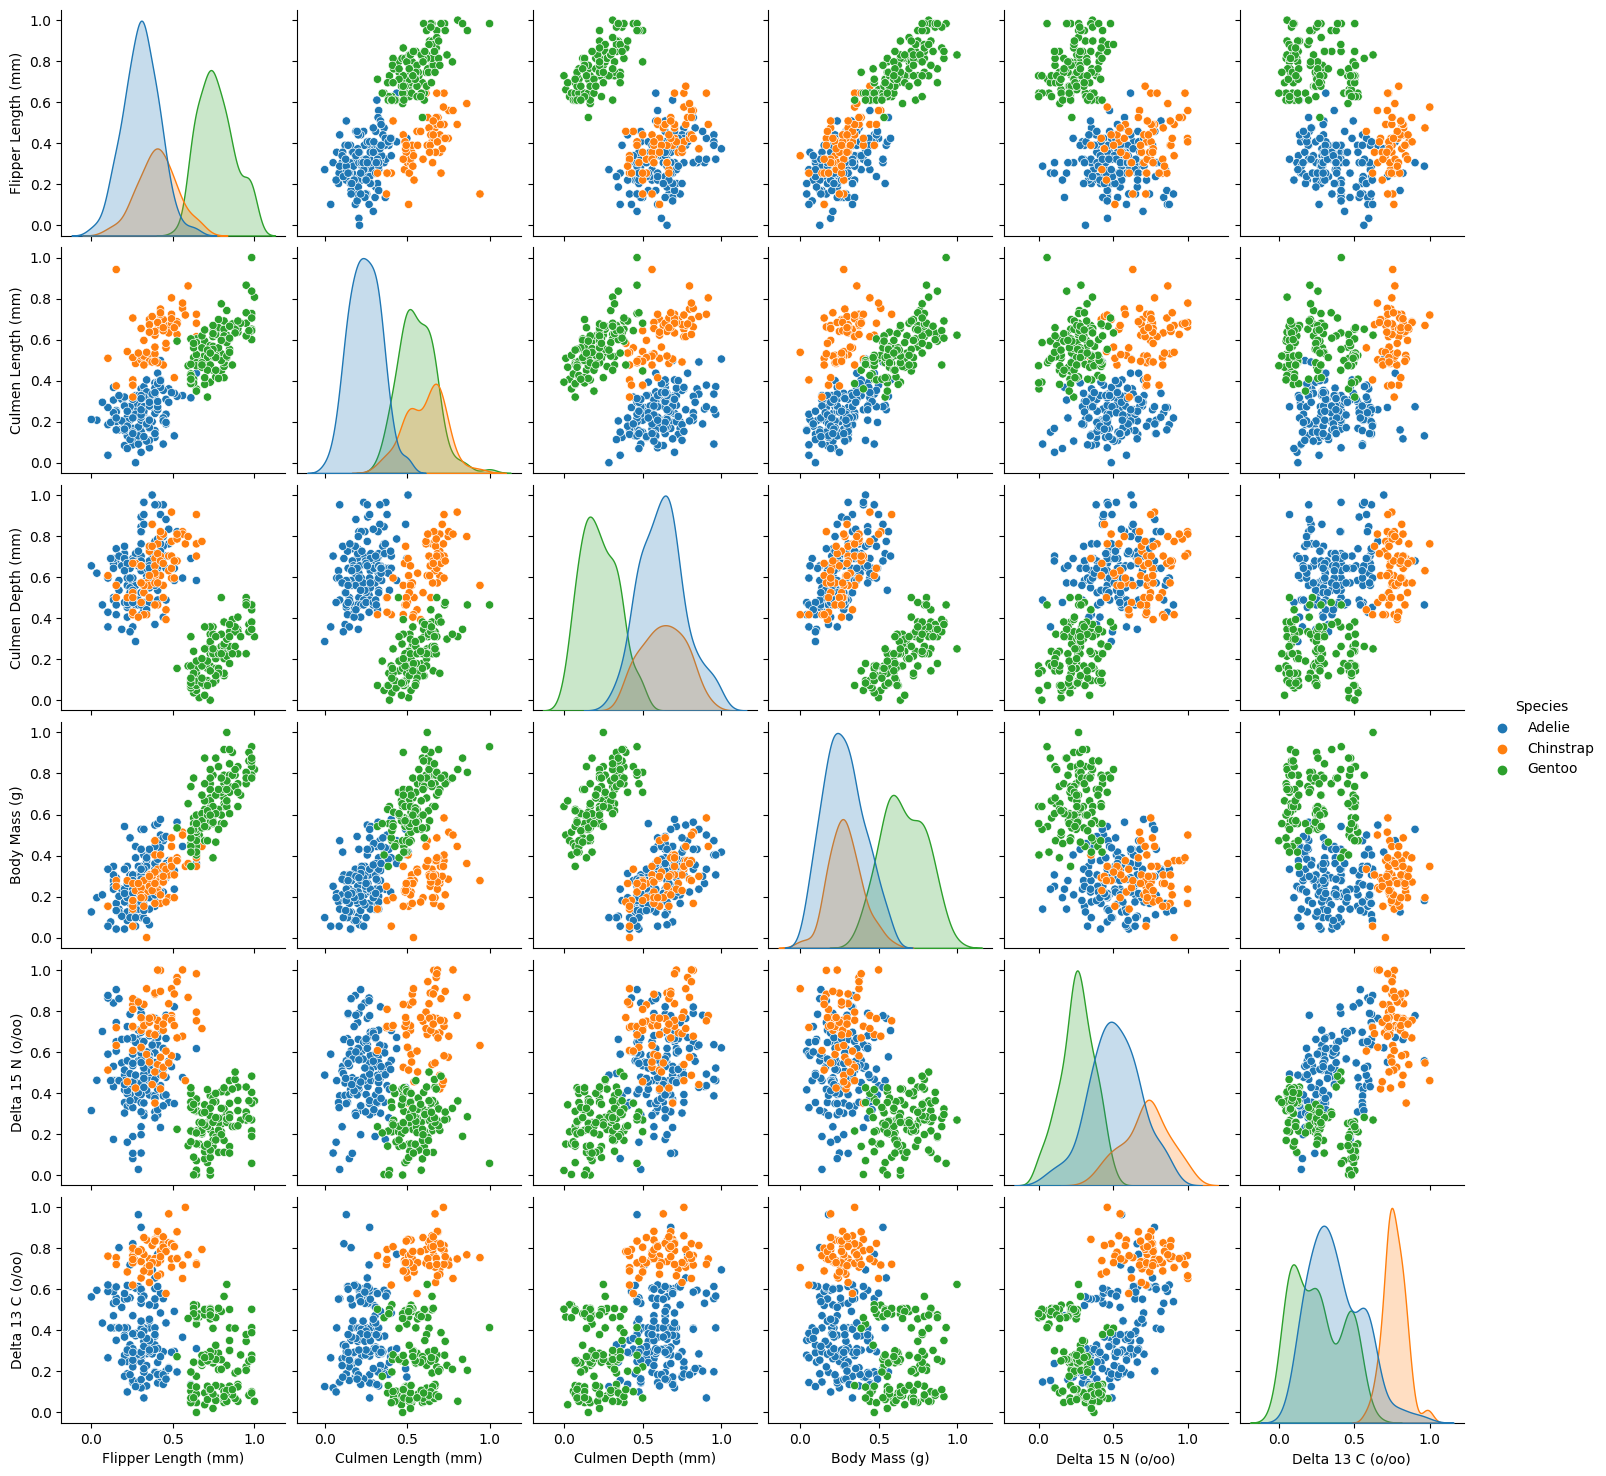

In [18]:
plt.figure(figsize=(7,7))
#sns.set_style('whitegrid')
sns.pairplot(data=df_normalized_min_max, hue='Species')#, palette=('DarkOrange', 'MediumOrchid', 'Teal'))

<Figure size 700x700 with 0 Axes>

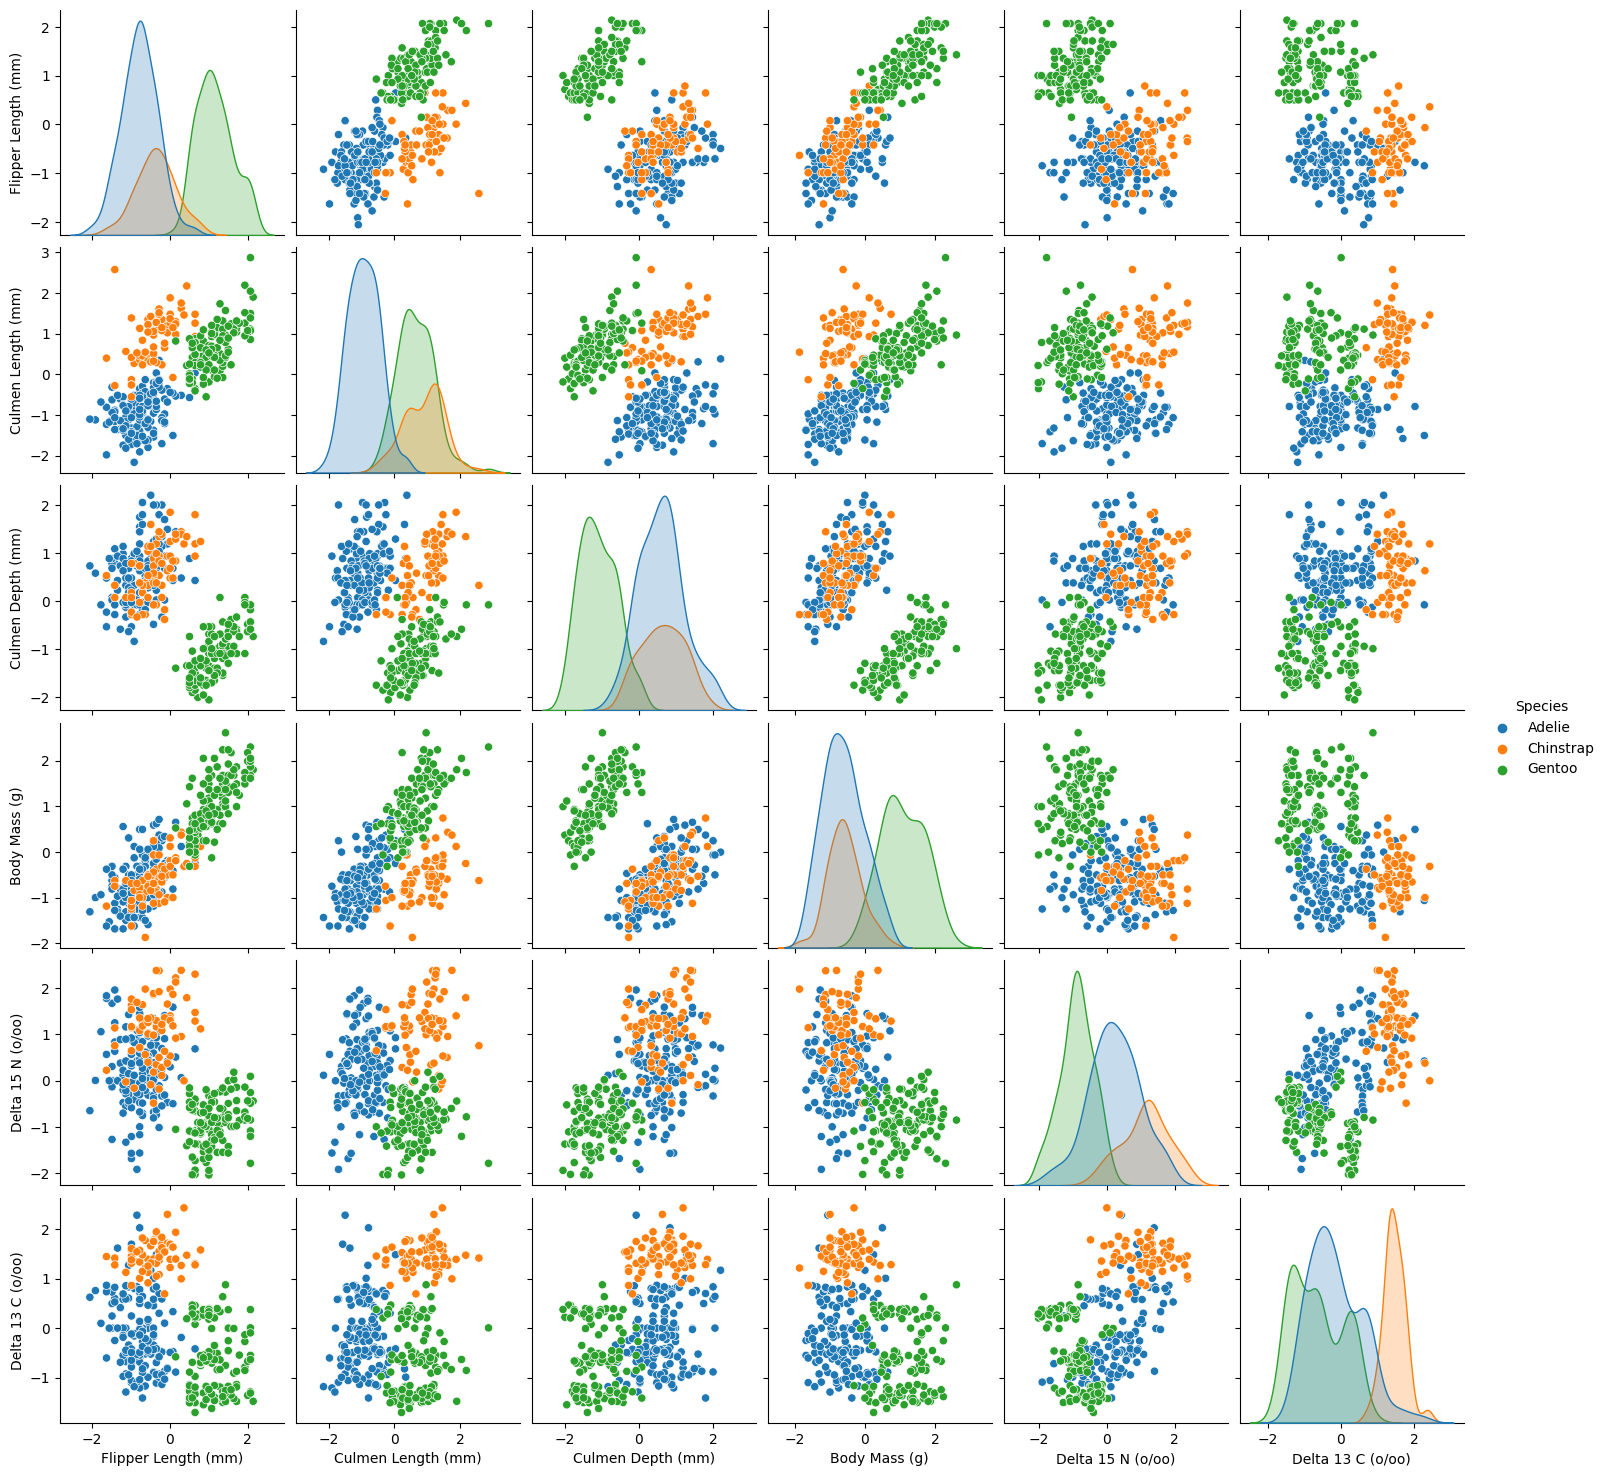

In [19]:
plt.figure(figsize=(7,7))
#sns.set_style('whitegrid')
sns.pairplot(data=df_normalized_z_scale, hue='Species')#, palette=('DarkOrange', 'MediumOrchid', 'Teal'))

<Figure size 700x700 with 0 Axes>

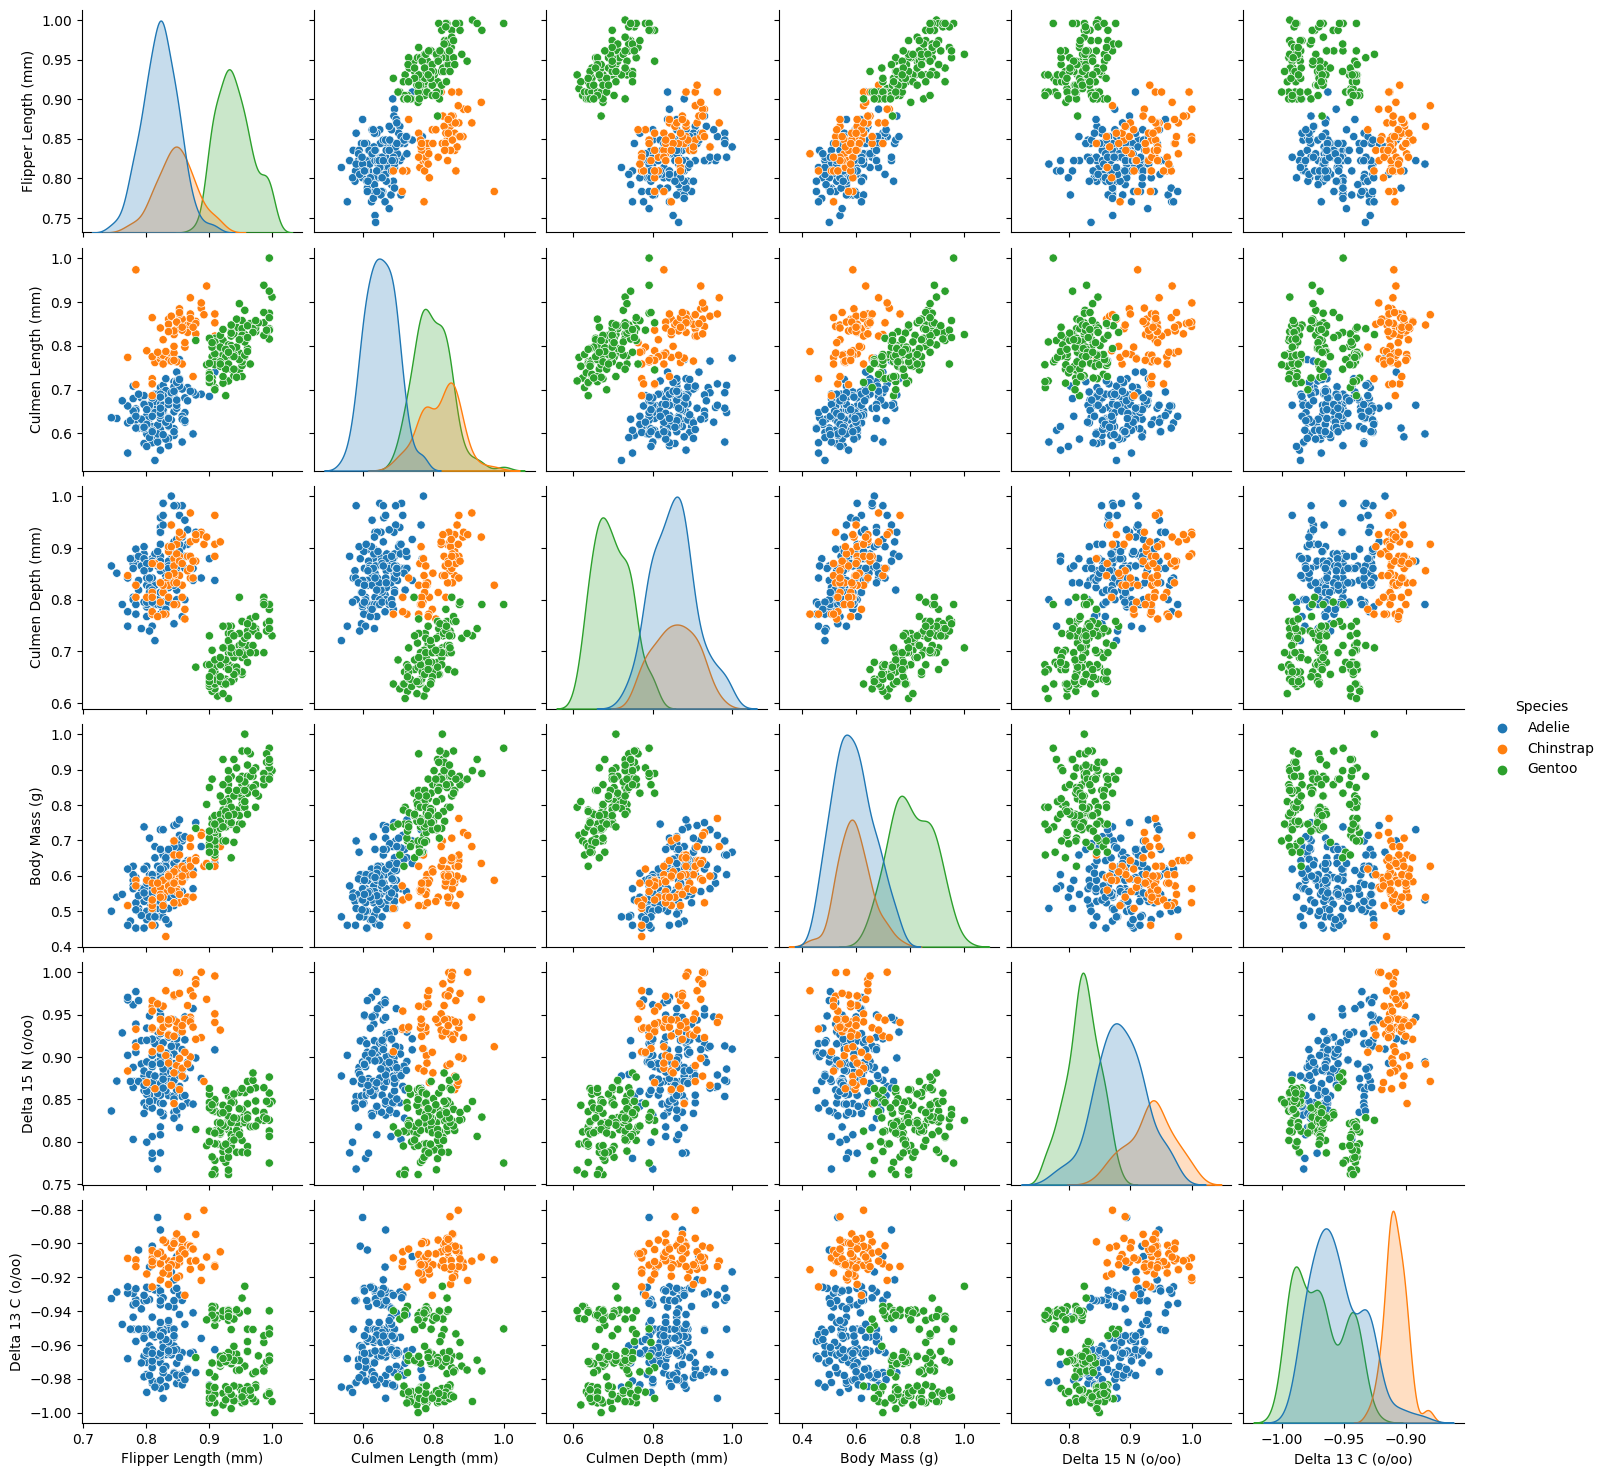

In [20]:
plt.figure(figsize=(7,7))
#sns.set_style('whitegrid')
sns.pairplot(data=df_max_scaled, hue='Species')#, palette=('DarkOrange', 'MediumOrchid', 'Teal'))

[[0.29559322 0.23941818]
 [0.76204979 0.56011364]
 [0.40201271 0.61585227]]


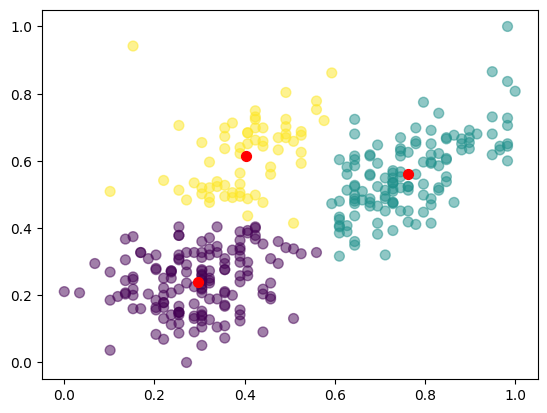

In [21]:
k_means_data = df_normalized_min_max[['Flipper Length (mm)', 'Culmen Length (mm)']]
# k_means_data.head()

kmeans = KMeans(n_clusters=3).fit(k_means_data)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(k_means_data['Flipper Length (mm)'], k_means_data['Culmen Length (mm)'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()